In [1]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor

from sklearn.tree import DecisionTreeRegressor, export_graphviz

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

from xgboost import XGBRegressor

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the data

df = pd.read_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Data/df_final_new.csv')

# extract the feature and target from the dataset
X_dev = df.loc[:, df.columns != 'price']
y_dev = df.loc[:, df.columns == 'price']



## Dimension Reduction

Considering the colinearity in the dataframe, we could possibly perform a dimension reduction to eliminate the redundant computation.

In [ ]:
def PCA_test_models(model):
  train_mae_ls = []
  train_rsq_ls = []
  test_mae_ls = []
  test_rsq_ls = []

  for i in range(10, X_dev.shape[1]-5):
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(X_dev)
    principalDf = pd.DataFrame(data = principalComponents)
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(principalDf, 
                                                      y_dev, 
                                                      test_size=0.2,  
                                                      random_state=123)
    model.fit(X_train, y_train)
    train_mae = mean_absolute_error(y_train, 
                                      model.predict(X_train))

    test_mae = mean_absolute_error(y_test, 
                                     model.predict(X_test))
    
    train_mae_ls.append(train_mae)
    test_mae_ls.append(test_mae)
    train_rsq_ls.append(model.score(X_train, y_train))
    test_rsq_ls.append(model.score(X_test, y_test))
    
  results = pd.DataFrame(list(zip(train_mae_ls, 
                               test_mae_ls, 
                               train_rsq_ls, 
                               test_rsq_ls)),
                          columns =['Train_Mae', 
                                    'Test_Mae',
                                    'Train_R',
                                    'Test_R'])
  return results

In [ ]:
rf = RandomForestRegressor(random_state = 123, 
                           bootstrap = False, 
                           max_depth = 50, 
                           max_features = 'log2',
                           min_samples_split = 5)

result_rf = PCA_test_models(rf)

gbr = GradientBoostingRegressor(random_state = 123, 
                           max_depth =50, 
                           n_estimators=25)

result_gbr = PCA_test_models(gbr)

In [ ]:
result_rf.to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/RF_Results.csv',
                 index = False)
result_gbr.to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/GBR_Results.csv',
                  index = False)

#### Visualize the Results

In [ ]:
def plot_results(result,name):

  train_mae_ls = list(result['Train_Mae'])
  test_mae_ls = list(result['Test_Mae'])
  train_rsq_ls = list(result['Train_R'])
  test_rsq_ls = list(result['Test_R'])

  x = range(10, X_dev.shape[1]-5)  

  fig, ax = plt.subplots(2, sharex='col', sharey='row',figsize = [5,10])
  title = 'Performance of '+name
  fig.suptitle(title)
  #fig.suptitle('Performance of '+name)

  ax[0].plot(x, train_mae_ls,label = 'Training MAE')
  ax[0].plot(x, test_mae_ls,label = 'Testing MAE')
  ax[0].set_title('Mean Absolute Error of Training and Testing Dataset')
  ax[0].set_ylabel('MAE')
  # ax[0].set_xlabel('N_Components')
  ax[0].set_ylim([0, 35])
  ax[0].legend()

  ax[1].plot(x, train_rsq_ls,label = 'Training R Square')
  ax[1].plot(x, test_rsq_ls,label = 'Testing R Square')
  ax[1].set_title('R Square value of Training and Testing Dataset')
  ax[1].set_ylabel('R Square')
  ax[1].set_xlabel('N_Components')
  ax[1].set_ylim([-0.2, 1])
  ax[1].legend()

  plt.savefig('drive/MyDrive/Hotel-Room-Price-Estimation/Figures/'+title+'.png')
  plt.show()

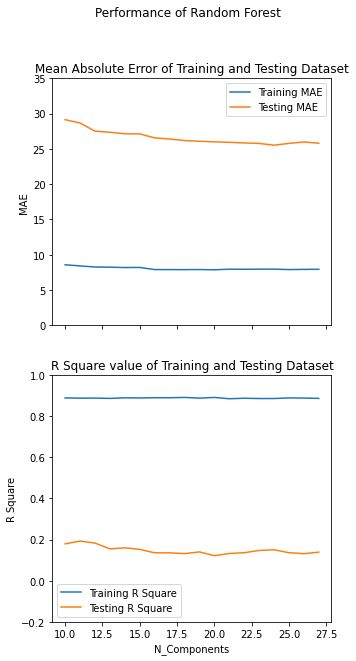

In [ ]:
result_rf = pd.read_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/RF_Results.csv')
plot_results(result_rf,"Random Forest")

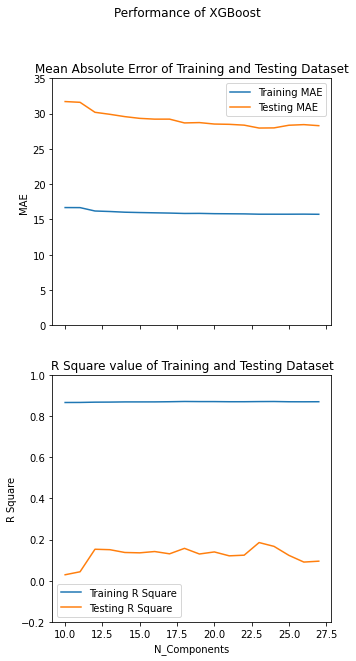

In [ ]:
result_xgb = pd.read_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/XGB_Results.csv')
plot_results(result_xgb,"XGBoost")

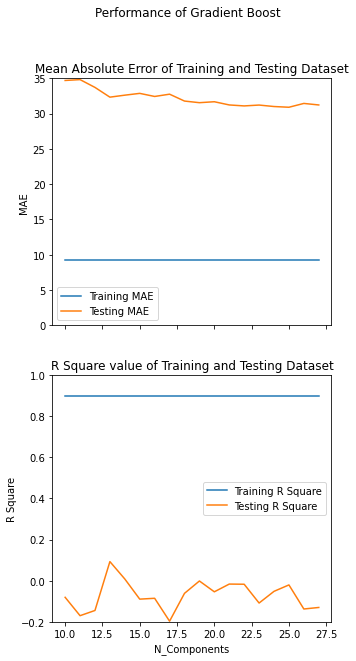

In [ ]:
result_gbr = pd.read_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/GBR_Results.csv')
plot_results(result_gbr,"Gradient Boost")

## Neural Network

### Basic Settings

In [3]:
# Load the data

df = pd.read_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Data/df_final_new.csv')

# extract the feature and target from the dataset
X_dev = df.loc[:, df.columns != 'price']
y_dev = df.loc[:, df.columns == 'price']

X_train, X_test, y_train, y_test = train_test_split(X_dev, 
                                                    y_dev, 
                                                    test_size=0.2,  
                                                    random_state=123)

train = X_train
target = y_train

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4352      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 169,217
Trainable params: 169,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode ='auto')

callbacks_list = [checkpoint]


In [ ]:
history =NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
3512/3523 [============================>.] - ETA: 0s - loss: 42.5279 - mean_absolute_error: 42.5279
Epoch 1: val_loss improved from 42.59772 to 42.39346, saving model to Weights-001--42.39346.hdf5
3523/3523 [==============================] - 14s 4ms/step - loss: 42.5228 - mean_absolute_error: 42.5228 - val_loss: 42.3935 - val_mean_absolute_error: 42.3935
Epoch 2/500
3520/3523 [============================>.] - ETA: 0s - loss: 42.4440 - mean_absolute_error: 42.4440
Epoch 2: val_loss did not improve from 42.39346
3523/3523 [==============================] - 14s 4ms/step - loss: 42.4395 - mean_absolute_error: 42.4395 - val_loss: 42.4361 - val_mean_absolute_error: 42.4361
Epoch 3/500
3522/3523 [============================>.] - ETA: 0s - loss: 42.2523 - mean_absolute_error: 42.2523
Epoch 3: val_loss improved from 42.39346 to 42.01411, saving model to Weights-003--42.01411.hdf5
3523/3523 [==============================] - 16s 4ms/step - loss: 42.2522 - mean_absolute_error: 42.25

In [ ]:

# Save it under the form of a json file
pd.DataFrame.from_dict(history.history).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/History1.csv',
                                       index=False)


In [22]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(24, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.5))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 24)                816       
                                                                 
 dense_36 (Dense)            (None, 64)                1600      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 128)               8320      
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dropout_23 (Dropout)        (None, 128)              

In [23]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode ='auto')

callbacks_list = [checkpoint]

history2 =NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
3513/3523 [============================>.] - ETA: 0s - loss: 54.8616 - mean_absolute_error: 54.8616
Epoch 1: val_loss improved from inf to 50.22306, saving model to Weights-001--50.22306.hdf5
3523/3523 [==============================] - 12s 3ms/step - loss: 54.8559 - mean_absolute_error: 54.8559 - val_loss: 50.2231 - val_mean_absolute_error: 50.2231
Epoch 2/500
3520/3523 [============================>.] - ETA: 0s - loss: 50.7181 - mean_absolute_error: 50.7181
Epoch 2: val_loss improved from 50.22306 to 46.06493, saving model to Weights-002--46.06493.hdf5
3523/3523 [==============================] - 12s 3ms/step - loss: 50.7173 - mean_absolute_error: 50.7173 - val_loss: 46.0649 - val_mean_absolute_error: 46.0649
Epoch 3/500
3521/3523 [============================>.] - ETA: 0s - loss: 49.9401 - mean_absolute_error: 49.9401
Epoch 3: val_loss did not improve from 46.06493
3523/3523 [==============================] - 11s 3ms/step - loss: 49.9353 - mean_absolute_error: 49.9353 - 

In [24]:
pd.DataFrame.from_dict(history2.history).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/History2.csv',
                                       index=False)

predictions2 = NN_model.predict(X_test)

pd.DataFrame(predictions2).to_csv('drive/MyDrive/Hotel-Room-Price-Estimation/Cache/Prediction2.csv',
                                       index=False)